# Denoising Diffusion Probabilistic Models (DDPM) on MNIST

In [1]:
# Python imports
import random
import math
import abc
import os

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
from tabulate import tabulate

# Own imports
import utils

## 0. Constants

In [2]:
# Hyper-parameters.
LEARNING_RATE_START = 5e-4
EPOCHS = 10
BATCH_SIZE = 64
GROUP_NORM_GROUPS = 32

# Diffusion model parameters.
TIME_STEPS = 500

# Dataset parameters.
WIDTH = 28
HEIGHT = 28
CHANNELS = 1

# Others
SAVED_FILENAME = 'MNIST'

### 0.1. Device

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Print the device to run the model.
print(f"Use device [{DEVICE}].")

Use device [cuda].


## 1. Dataset

In [4]:
# 1. Each item in dataset is a tuple of (torch.Tensor, int). The first tensor is of shape (CHANNELS, HEIGHT, WIDTH) and dtype torch.float32, which is the image.
# 2. I use a custom utils.MNIST to load and cache the dataset, so that reading from hard drive during training is avoided.
dataset = utils.MNIST(
    './data',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Resize((HEIGHT, WIDTH), antialias=True),
        torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
    ]),
)

# samples = next(iter(dataloader))
# samples is a Python list of len 2.
# samples[0] is a tensor of shape (BATCH_SIZE, CHANNELS, WIDTH, HEIGHT)
# samples[1] is a tensor of shape (BATCH_SIZE,)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Inspect statistics of the dataset.

In [5]:
# Get the size of the dataset.
dataset_size = len(dataset)

# Construct data structures used by tabulate.
headers = ['Property', 'Value']
rows = [
    ['Size', dataset_size],
]

# Print the table.
print(tabulate(rows, headers=headers, tablefmt='github'))

| Property   |   Value |
|------------|---------|
| Size       |   60000 |


Inspect samples from the dataset.

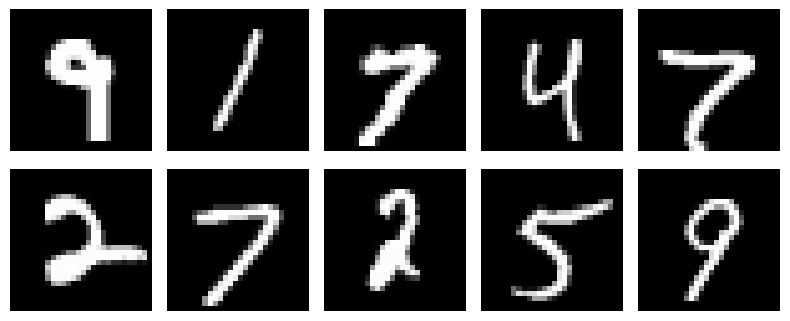

In [6]:
# Sample 10 unique indices from the index range of the dataset.
indices = random.sample(range(dataset_size), k=10)

# Plot figure.
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(8, 3.5))
for i in range(len(indices)):
    row = i // cols
    col = i % cols
    axs[row][col].imshow(dataset[indices[i]][0].permute(1, 2, 0), cmap=plt.cm.gray)
    axs[row][col].axis('off')
plt.tight_layout()
plt.show()

## 2. Diffusion

In [13]:
class Diffusion:
    """Difusion class performs forward and backward diffusion."""

    def __init__(self, time_steps=1000):
        """
        Args:
            timesteps (int): maximum diffusion timesteps.
        """

        # Remember the instance attributes.
        self.time_steps = time_steps

        # Perform pre-calculations.
        self._performPreCalculations()

    def q_sample(self):
        """Perform forward diffusion."""

        pass

    def _beta_schedule(self):
        """Generate betas for adding noise to images in a linear way.

        The article [1] uses 1000 time steps, and uses 0.0001 as the starting beta and 0.02 as the ending beta.
        If we use a different time steps, we need to scale it to make sure the noised added is enough.

        Return: A tensor of shape (self.time_steps,) and dtype torch.float32.
        """

        # Calculate the scale of the starting and ending betas.
        scale = 1000 / self.time_steps

        # Scale the starting and ending betas.
        beta_start_scaled = 0.0001 * scale
        beta_end_scaled = 0.02 * scale

        # Return a tensor of shape (self.time_steps,) and dtype torch.float32.
        return torch.linspace(start=beta_start_scaled, end=beta_end_scaled, steps=self.time_steps, device=DEVICE)

    def _performPreCalculations(self):
        """Perform pre-calculations."""

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        betas = self._beta_schedule()

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        alphas = 1 - betas

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        self.alphas_cumprod = alphas.cumprod(dim=0)

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod).sqrt()

diffusion = Diffusion(TIME_STEPS)